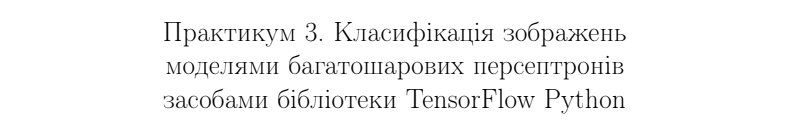

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_addons.metrics import F1Score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import os, datetime

Для того, щоб можна було запускати TensorBoard

In [2]:
%load_ext tensorboard

In [3]:
import hub

ds = hub.load("hub://activeloop/kuzushiji-kanji")

/home/nerbivol/.local/lib/python3.10/site-packages/hub/util/check_latest_version.py:32: UserWarning: A newer version of hub (2.4.2) is available. It's recommended that you update to the latest version using `pip install -U hub`.
  warnings.warn(


Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/kuzushiji-kanji loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/kuzushiji-kanji


In [4]:
X = ds.images[0:25000].numpy() 
Y = ds.labels[0:25000].numpy()

(64, 64)

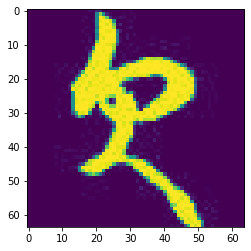

In [110]:
plt.imshow(X[5])

In [6]:
from sklearn import preprocessing

ohe = preprocessing.OneHotEncoder()

ohe.fit(Y)
y = ohe.transform(Y).toarray()

In [7]:
y.shape

(25000, 652)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=1)

In [9]:
print("Training matrix shape", X_train.shape)
print("Valid matrix shape", X_valid.shape)
print("Train features shape", y_train.shape)
print("Valid features shape", y_valid.shape)

Training matrix shape (20000, 64, 64)
Valid matrix shape (5000, 64, 64)
Train features shape (20000, 652)
Valid features shape (5000, 652)


In [10]:
X_train = X_train.astype('float32').reshape(-1, 64*64) / 255.0
X_valid = X_valid.astype('float32').reshape(-1, 64*64) / 255.0

In [11]:
print("Training matrix shape", X_train.shape)
print("Train features shape", y_train.shape)

Training matrix shape (20000, 4096)
Train features shape (20000, 652)


Застосуємо One Hot Encoder для кращого навчанння наших даних.

In [12]:
metrics = [
    'accuracy',
    F1Score(652, average='macro', name='f1'),
    tf.keras.metrics.AUC(name='auc')
]

2022-05-11 13:14:42.387686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 13:14:43.238189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-11 13:14:43.238259: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-11 13:14:43.289184: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

### Baseline model - softmax layer

In [73]:
normal_init = tf.random_normal_initializer(mean=0.0, stddev=1.0)
    
baseline_model = keras.Sequential([
    layers.Dense(652, input_shape=[64*64],
                 activation='softmax',
                 kernel_initializer=normal_init)
    ])

baseline_model.compile(
        optimizer="SGD",
        loss='categorical_crossentropy',
        metrics=metrics
)

logdir = "logs/kkanji/base"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = baseline_model.fit(X_train,y_train, 
                             validation_data=(X_valid, y_valid),
                            epochs=30,
                            callbacks=[tensorboard_callback])

Epoch 1/30
625/625 [==============================] - 16s 17ms/step - loss: 62.3303 - accuracy: 0.0437 - f1: 0.0017 - auc: 0.5292 - val_loss: 52.8273 - val_accuracy: 0.0790 - val_f1: 0.0032 - val_auc: 0.5511
Epoch 2/30
625/625 [==============================] - 6s 10ms/step - loss: 47.6365 - accuracy: 0.1133 - f1: 0.0046 - auc: 0.5710 - val_loss: 44.2361 - val_accuracy: 0.1340 - val_f1: 0.0062 - val_auc: 0.5823
Epoch 3/30
625/625 [==============================] - 6s 9ms/step - loss: 41.1829 - accuracy: 0.1603 - f1: 0.0075 - auc: 0.5992 - val_loss: 39.6536 - val_accuracy: 0.1744 - val_f1: 0.0085 - val_auc: 0.6049
Epoch 4/30
625/625 [==============================] - 6s 10ms/step - loss: 37.3336 - accuracy: 0.1981 - f1: 0.0100 - auc: 0.6207 - val_loss: 36.7196 - val_accuracy: 0.2036 - val_f1: 0.0113 - val_auc: 0.6265
Epoch 5/30
625/625 [==============================] - 6s 10ms/step - loss: 34.6774 - accuracy: 0.2283 - f1: 0.0124 - auc: 0.6382 - val_loss: 34.5684 - val_accuracy: 0.2324 

In [74]:
pd.Series({k:v[-1] for k, v in history.history.items()})

loss            16.929777
accuracy         0.464400
f1               0.055694
auc              0.764534
val_loss        20.216545
val_accuracy     0.426600
val_f1           0.044907
val_auc          0.742540
dtype: float64

In [15]:
%tensorboard --logdir logs  #для відображення TensorBoard в notebook

Коли ми навчаємо модель, ми робимо графік втрати на навчальному наборі епоху за епохою. А також додаємо графік даних перевірки. Ці графіки називаються кривими навчання.

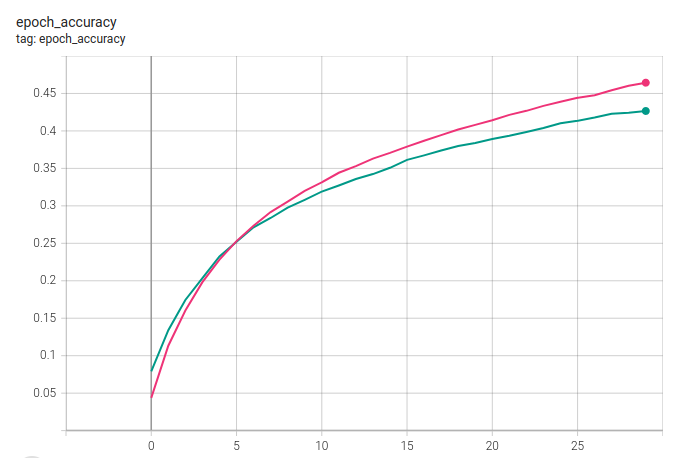
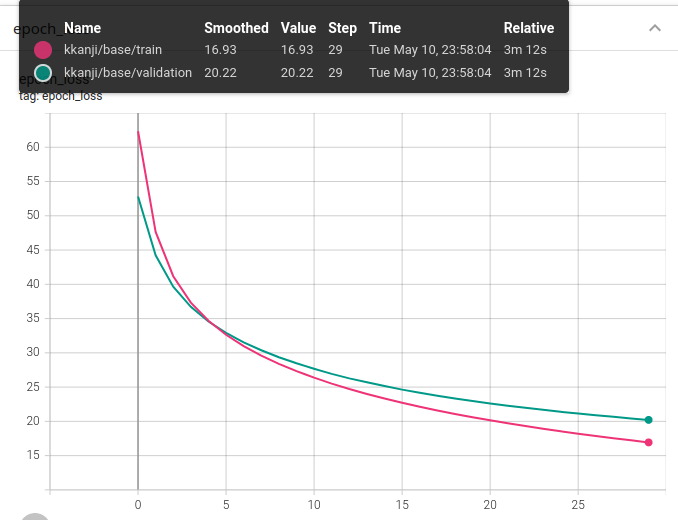

#### Порівняємо ReLU і tanh

In [22]:
def model_define(initializer, activation, learning_rate=0.01,  input_shape=[1]):
    model = keras.Sequential([
    layers.Dense(512, input_shape=input_shape,
                 activation=activation,
                 kernel_initializer=initializer),
    layers.Dense(512, activation=activation,
                kernel_initializer=initializer),
    layers.Dense(512, activation=activation,
                kernel_initializer=initializer),
    layers.Dense(units=652, activation='softmax'),
    ])

    opt = keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(
        optimizer="SGD",
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    history = model.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=35)
    
    return model, history

In [23]:
initializer_glorot = tf.initializers.GlorotNormal()
activation_tanh = 'tanh'

model_tanh, history_tanh = model_define(initializer_glorot, activation_tanh, 
                              input_shape=[64*64])

Epoch 1/35
625/625 [==============================] - 9s 13ms/step - loss: 4.0065 - accuracy: 0.3400 - f1: 0.0245 - auc: 0.7990 - val_loss: 3.2584 - val_accuracy: 0.4344 - val_f1: 0.0185 - val_auc: 0.8574
Epoch 2/35
625/625 [==============================] - 7s 11ms/step - loss: 2.9206 - accuracy: 0.4866 - f1: 0.0307 - auc: 0.8746 - val_loss: 2.7227 - val_accuracy: 0.5232 - val_f1: 0.0383 - val_auc: 0.8877
Epoch 3/35
625/625 [==============================] - 8s 13ms/step - loss: 2.4884 - accuracy: 0.5583 - f1: 0.0483 - auc: 0.9018 - val_loss: 2.4303 - val_accuracy: 0.5692 - val_f1: 0.0516 - val_auc: 0.9059
Epoch 4/35
625/625 [==============================] - 9s 14ms/step - loss: 2.2060 - accuracy: 0.6013 - f1: 0.0619 - auc: 0.9194 - val_loss: 2.2339 - val_accuracy: 0.5996 - val_f1: 0.0619 - val_auc: 0.9156
Epoch 5/35
625/625 [==============================] - 8s 13ms/step - loss: 1.9951 - accuracy: 0.6315 - f1: 0.0755 - auc: 0.9307 - val_loss: 2.0914 - val_accuracy: 0.6232 - val_f1: 

In [24]:
pd.Series({k:v[-1] for k, v in history_tanh.history.items()})

loss            0.390145
accuracy        0.944600
f1              0.463147
auc             0.995852
val_loss        1.259957
val_accuracy    0.747400
val_f1          0.204088
val_auc         0.962330
dtype: float64

In [19]:
def plot_loss_accuraccy(history):
    history_df = pd.DataFrame(history.history)
    print("Maximum accuracy: {}".format(history_df['val_accuracy'].max()))
    history_df[['loss', 'val_loss']].plot()
    history_df[['accuracy', 'val_accuracy']].plot()

Maximum accuracy: 0.7473999857902527


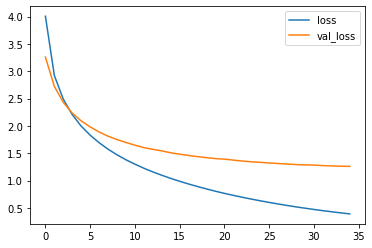

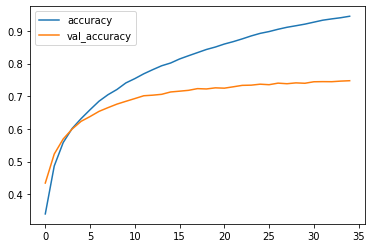

In [25]:
plot_loss_accuraccy(history_tanh)

In [26]:
initializer_he = tf.initializers.HeNormal()
activation_relu = 'relu'

model_relu, history_relu = model_define(initializer_he, activation_relu, 
                              input_shape=[64*64])

model_relu.save('models/model_relu')

Epoch 1/35
625/625 [==============================] - 8s 12ms/step - loss: 3.7139 - accuracy: 0.3871 - f1: 0.0783 - auc: 0.8561 - val_loss: 2.7839 - val_accuracy: 0.5156 - val_f1: 0.0417 - val_auc: 0.8966
Epoch 2/35
625/625 [==============================] - 9s 14ms/step - loss: 2.3681 - accuracy: 0.5777 - f1: 0.0620 - auc: 0.9177 - val_loss: 2.2225 - val_accuracy: 0.5966 - val_f1: 0.0685 - val_auc: 0.9223
Epoch 3/35
625/625 [==============================] - 7s 11ms/step - loss: 1.8487 - accuracy: 0.6529 - f1: 0.1035 - auc: 0.9418 - val_loss: 1.9317 - val_accuracy: 0.6466 - val_f1: 0.1039 - val_auc: 0.9378
Epoch 4/35
625/625 [==============================] - 7s 11ms/step - loss: 1.5117 - accuracy: 0.7027 - f1: 0.1416 - auc: 0.9568 - val_loss: 1.7677 - val_accuracy: 0.6674 - val_f1: 0.1195 - val_auc: 0.9411
Epoch 5/35
625/625 [==============================] - 7s 11ms/step - loss: 1.2745 - accuracy: 0.7420 - f1: 0.1836 - auc: 0.9671 - val_loss: 1.6304 - val_accuracy: 0.6938 - val_f1: 

2022-05-11 13:48:19.957689: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model_relu/assets
Assets written to: models/model_relu/assets


In [29]:
pd.Series({k:v[-1] for k, v in history_relu.history.items()})

loss            0.013749
accuracy        0.999800
f1              0.950857
auc             0.999950
val_loss        1.530408
val_accuracy    0.764600
val_f1          0.249437
val_auc         0.947570
dtype: float64

Maximum accuracy: 0.7648000121116638


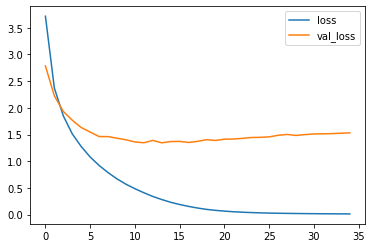

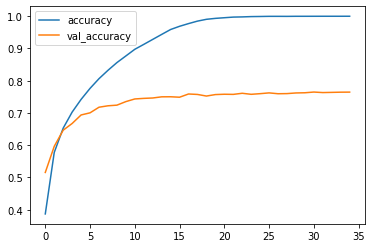

In [30]:
plot_loss_accuraccy(history_relu)

Отже, з вище проведених іналіз даних можна зробити висновок, що найкращу модель отримали під час ініціалізації ваг методом Хе при значенні accuracy: 0.7646 далі іде ініціалізації ваг методом Глоро - accuracy: 0.7473 і далі традиційна із accuracy: 0.42.

Дані графіках кривих навчання показують наскільки ефективно начаются моделі. Функції втрат прямують до 0, а accuracy до 1. </br>
У випадку коли модель навчається довго, то виникає проблема переначання, коли модель враховує великує частину шуму і врешті не здатна коректно прогозувати дані. Тобто в даному випадку фунція втрат на навчальних даних продовжує прямувати до 0, а на даних перевірці(x_valid) почне зростати. І в протилежному випадку на графіках accuracy.

Серед наведених вище графіках переначання спостерігається лише серед останьої моделі. Хоч це перенавчання не значне, але на графіках втрат помітно те що val_loss зростає.

##### Дослідимо різні функції активації: LeakyReLU, Parametric LeakyReLU, ELU.

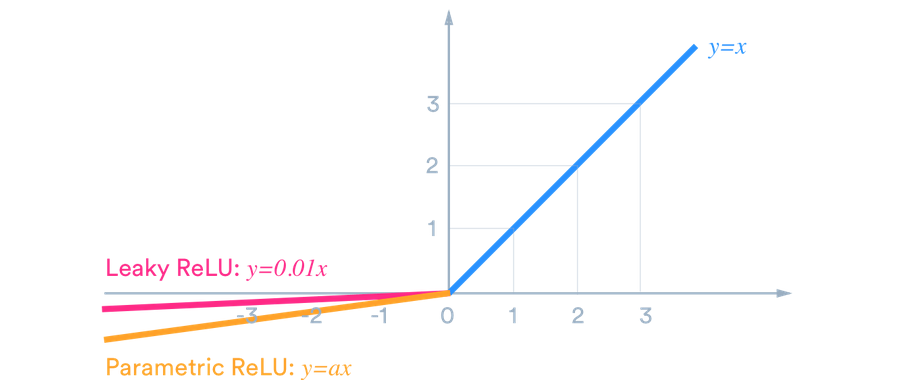
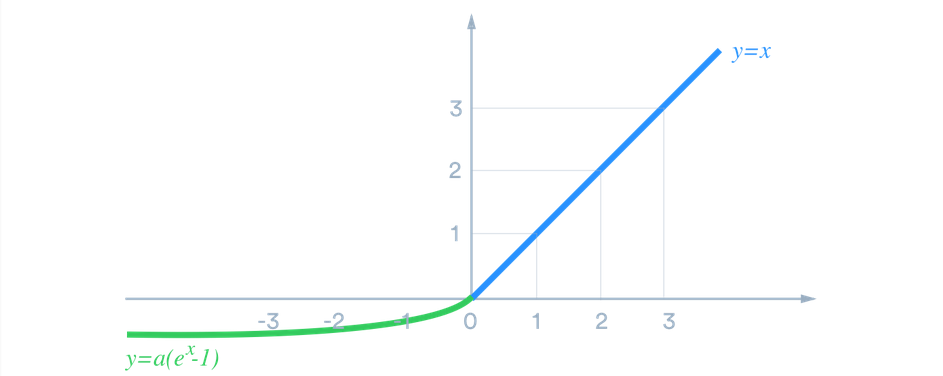

#### Для LeakyReLU

In [31]:
activation_lrelu = layers.LeakyReLU()

model_lrelu, history_lrelu = model_define(initializer_he, activation_lrelu, 
                              input_shape=[64*64])

model_lrelu.save('models/model_lrelu')

Epoch 1/35
625/625 [==============================] - 8s 12ms/step - loss: 3.5434 - accuracy: 0.4132 - f1: 0.1000 - auc: 0.8624 - val_loss: 2.6727 - val_accuracy: 0.5418 - val_f1: 0.0483 - val_auc: 0.9025
Epoch 2/35
625/625 [==============================] - 7s 11ms/step - loss: 2.2434 - accuracy: 0.5996 - f1: 0.0747 - auc: 0.9236 - val_loss: 2.1567 - val_accuracy: 0.6006 - val_f1: 0.0772 - val_auc: 0.9249
Epoch 3/35
625/625 [==============================] - 7s 11ms/step - loss: 1.7445 - accuracy: 0.6708 - f1: 0.1206 - auc: 0.9457 - val_loss: 1.8660 - val_accuracy: 0.6528 - val_f1: 0.1160 - val_auc: 0.9403
Epoch 4/35
625/625 [==============================] - 7s 11ms/step - loss: 1.4199 - accuracy: 0.7194 - f1: 0.1633 - auc: 0.9606 - val_loss: 1.7452 - val_accuracy: 0.6696 - val_f1: 0.1370 - val_auc: 0.9428
Epoch 5/35
625/625 [==============================] - 7s 11ms/step - loss: 1.1897 - accuracy: 0.7569 - f1: 0.2071 - auc: 0.9705 - val_loss: 1.5981 - val_accuracy: 0.6890 - val_f1: 

In [32]:
pd.Series({k:v[-1] for k, v in history_lrelu.history.items()})

loss            0.014009
accuracy        0.999800
f1              0.950857
auc             0.999950
val_loss        1.663398
val_accuracy    0.756200
val_f1          0.247985
val_auc         0.942072
dtype: float64

Перевіримо час навчання мережі із функцiєю активацiї LeakyReLU:

In [33]:
%time model_lrelu.fit(X_train, y_train)

625/625 [==============================] - 6s 10ms/step - loss: 0.0133 - accuracy: 0.9998 - f1: 0.9509 - auc: 0.9999
CPU times: user 28.3 s, sys: 1.45 s, total: 29.7 s
Wall time: 7.91 s


Перевіримо час надання прогнозу

In [34]:
%time y_pred_lrelu = model_lrelu.predict(X_valid)

CPU times: user 3.01 s, sys: 119 ms, total: 3.12 s
Wall time: 1.65 s


#### Для Parametric LeakyReLU

In [35]:
activation_prelu = layers.PReLU(alpha_initializer=keras.initializers.Constant(value=0.25))

model_prelu = keras.Sequential([
    layers.Dense(512, input_shape=[64*64],
                 kernel_initializer=initializer_he),
    layers.PReLU(),
    layers.Dense(512, kernel_initializer=initializer_he),
    layers.PReLU(),
    layers.Dense(512, kernel_initializer=initializer_he),
    layers.PReLU(),
    layers.Dense(units=652, activation='softmax'),
    ])

model_prelu.compile(
        optimizer="SGD",
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
history = model_prelu.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=30)

model_prelu.save('models/model_prelu')

Epoch 1/30
625/625 [==============================] - 8s 12ms/step - loss: 3.7179 - accuracy: 0.3868 - f1: 0.6241 - auc: 0.9168 - val_loss: 2.8382 - val_accuracy: 0.5028 - val_f1: 0.0386 - val_auc: 0.8891
Epoch 2/30
625/625 [==============================] - 7s 11ms/step - loss: 2.3769 - accuracy: 0.5751 - f1: 0.0627 - auc: 0.9161 - val_loss: 2.2237 - val_accuracy: 0.6030 - val_f1: 0.0754 - val_auc: 0.9193
Epoch 3/30
625/625 [==============================] - 7s 12ms/step - loss: 1.8406 - accuracy: 0.6565 - f1: 0.1049 - auc: 0.9420 - val_loss: 1.9785 - val_accuracy: 0.6234 - val_f1: 0.1009 - val_auc: 0.9310
Epoch 4/30
625/625 [==============================] - 7s 12ms/step - loss: 1.5057 - accuracy: 0.7076 - f1: 0.1462 - auc: 0.9571 - val_loss: 1.8180 - val_accuracy: 0.6524 - val_f1: 0.1138 - val_auc: 0.9373
Epoch 5/30
625/625 [==============================] - 6s 10ms/step - loss: 1.2592 - accuracy: 0.7458 - f1: 0.1866 - auc: 0.9678 - val_loss: 1.6350 - val_accuracy: 0.6926 - val_f1: 

In [36]:
pd.Series({k:v[-1] for k, v in history.history.items()})

loss            0.018678
accuracy        0.999750
f1              0.950843
auc             0.999925
val_loss        1.506916
val_accuracy    0.760800
val_f1          0.240733
val_auc         0.950445
dtype: float64

In [37]:
%time model_prelu.fit(X_train, y_train)

625/625 [==============================] - 7s 11ms/step - loss: 0.0172 - accuracy: 0.9998 - f1: 0.9508 - auc: 0.9999
CPU times: user 30.8 s, sys: 1.29 s, total: 32.1 s
Wall time: 6.96 s


In [38]:
%time y_pred_prelu = model_prelu.predict(X_valid)

CPU times: user 2.37 s, sys: 111 ms, total: 2.48 s
Wall time: 774 ms


#### Для ELU

In [39]:
activation_elu = layers.ELU()

model_elu, history_elu = model_define(initializer_he, activation_elu, 
                              input_shape=[64*64])

model_elu.save('models/model_elu')

Epoch 1/35
625/625 [==============================] - 16s 15ms/step - loss: 3.2040 - accuracy: 0.4636 - f1: 0.6312 - auc: 0.9311 - val_loss: 2.4151 - val_accuracy: 0.5718 - val_f1: 0.0591 - val_auc: 0.9118
Epoch 2/35
625/625 [==============================] - 9s 14ms/step - loss: 2.0040 - accuracy: 0.6313 - f1: 0.0925 - auc: 0.9329 - val_loss: 1.9862 - val_accuracy: 0.6364 - val_f1: 0.1010 - val_auc: 0.9291
Epoch 3/35
625/625 [==============================] - 8s 13ms/step - loss: 1.5506 - accuracy: 0.7013 - f1: 0.1446 - auc: 0.9547 - val_loss: 1.7570 - val_accuracy: 0.6734 - val_f1: 0.1336 - val_auc: 0.9407
Epoch 4/35
625/625 [==============================] - 9s 14ms/step - loss: 1.2632 - accuracy: 0.7446 - f1: 0.1934 - auc: 0.9677 - val_loss: 1.5918 - val_accuracy: 0.6940 - val_f1: 0.1513 - val_auc: 0.9502
Epoch 5/35
625/625 [==============================] - 9s 14ms/step - loss: 1.0444 - accuracy: 0.7841 - f1: 0.2474 - auc: 0.9762 - val_loss: 1.5137 - val_accuracy: 0.7092 - val_f1:

In [40]:
pd.Series({k:v[-1] for k, v in history_elu.history.items()})

loss            0.012100
accuracy        0.999850
f1              0.950858
auc             0.999950
val_loss        1.626079
val_accuracy    0.754400
val_f1          0.243317
val_auc         0.944179
dtype: float64

In [41]:
%time model_elu.fit(X_train, y_train)

625/625 [==============================] - 7s 11ms/step - loss: 0.0115 - accuracy: 0.9998 - f1: 0.9509 - auc: 1.0000
CPU times: user 30.6 s, sys: 1.2 s, total: 31.8 s
Wall time: 6.89 s


In [42]:
%time y_pred_elu = model_elu.predict(X_valid)

CPU times: user 2.11 s, sys: 87.2 ms, total: 2.2 s
Wall time: 685 ms


Отже ми отримали такі результати: </br>
- Час навчання мережі:
    - LeakyReLU: 29.7 s
    - Parametric LeakyReLU: 32.1 s
    - ELU: 31.8 s
    
- Якiсть роботи мережi на перевiрочнiй множинi:
    - LeakyReLU: 0.7562
    - Parametric LeakyReLU: 0.7608
    - ELU: 0.7544
- Час надання прогнозу мережею:
    - LeakyReLU: 3.12 s
    - Parametric LeakyReLU: 2.48 s
    - ELU: 2.2 s

#### Далі замiсть методу ґрадiєнтного спуску використаємо адаптивний метод Adam

In [43]:
def model_define_adam(initializer, activation, input_shape=[1]):
    model = keras.Sequential([
    layers.Dense(512, input_shape=input_shape,
                 activation=activation,
                 kernel_initializer=initializer),
    layers.Dense(512, activation=activation,
                kernel_initializer=initializer),
    layers.Dense(512, activation=activation,
                kernel_initializer=initializer),
    layers.Dense(units=652, activation='softmax'),
    ])

    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    history = model.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=30)
    
    return model, history

#### Normal ініціалізація

In [44]:
initializer_norm = tf.random_normal_initializer(mean=0.0, stddev=1.0)
activation_relu = 'relu'

model_adam_norm, history_adam_norm = model_define_adam(initializer_norm, activation_relu, 
                              input_shape=[64*64])

model_adam_norm.save('models/model_adam_norm')

Epoch 1/30
625/625 [==============================] - 10s 16ms/step - loss: 1738.5096 - accuracy: 0.3014 - f1: 0.4778 - auc: 0.8252 - val_loss: 620.2261 - val_accuracy: 0.3778 - val_f1: 0.0375 - val_auc: 0.6893
Epoch 2/30
625/625 [==============================] - 9s 15ms/step - loss: 318.7452 - accuracy: 0.4732 - f1: 0.1038 - auc: 0.7376 - val_loss: 382.8385 - val_accuracy: 0.4266 - val_f1: 0.0569 - val_auc: 0.7145
Epoch 3/30
625/625 [==============================] - 9s 15ms/step - loss: 129.5855 - accuracy: 0.6077 - f1: 0.3499 - auc: 0.8062 - val_loss: 336.5511 - val_accuracy: 0.4504 - val_f1: 0.0600 - val_auc: 0.7269
Epoch 4/30
625/625 [==============================] - 11s 17ms/step - loss: 60.4336 - accuracy: 0.7253 - f1: 0.6090 - auc: 0.8652 - val_loss: 331.2964 - val_accuracy: 0.4644 - val_f1: 0.0662 - val_auc: 0.7333
Epoch 5/30
625/625 [==============================] - 10s 15ms/step - loss: 34.2237 - accuracy: 0.8047 - f1: 0.7368 - auc: 0.9044 - val_loss: 329.2888 - val_accur

In [45]:
pd.Series({k:v[-1] for k, v in history_adam_norm.history.items()})

loss             11.632446
accuracy          0.966150
f1                0.910202
auc               0.983299
val_loss        595.493530
val_accuracy      0.597400
val_f1            0.104909
val_auc           0.798692
dtype: float64

Maximum accuracy: 0.6003999710083008


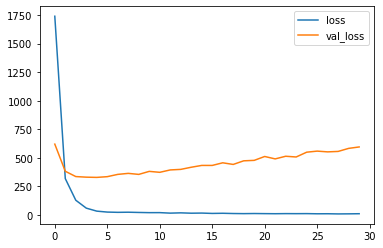

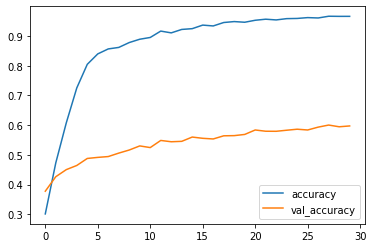

In [46]:
plot_loss_accuraccy(history_adam_norm)

#### Glorot ініціалізація

In [47]:
initializer_glorot = tf.initializers.GlorotNormal()
activation_tanh = 'tanh'

model_adam_glorot, history_adam_glorot = model_define_adam(initializer_glorot, activation_tanh, 
                              input_shape=[64*64])

model_adam_norm.save('models/model_adam_glorot')

Epoch 1/30
625/625 [==============================] - 11s 17ms/step - loss: 2.4050 - accuracy: 0.5430 - f1: 0.0853 - auc: 0.8883 - val_loss: 1.8089 - val_accuracy: 0.6320 - val_f1: 0.1137 - val_auc: 0.9425
Epoch 2/30
625/625 [==============================] - 9s 15ms/step - loss: 1.3970 - accuracy: 0.6949 - f1: 0.1805 - auc: 0.9640 - val_loss: 1.6315 - val_accuracy: 0.6628 - val_f1: 0.1583 - val_auc: 0.9511
Epoch 3/30
625/625 [==============================] - 9s 15ms/step - loss: 1.0117 - accuracy: 0.7613 - f1: 0.2802 - auc: 0.9791 - val_loss: 1.4618 - val_accuracy: 0.7066 - val_f1: 0.1810 - val_auc: 0.9535
Epoch 4/30
625/625 [==============================] - 9s 15ms/step - loss: 0.7711 - accuracy: 0.8064 - f1: 0.4293 - auc: 0.9872 - val_loss: 1.4967 - val_accuracy: 0.7016 - val_f1: 0.1834 - val_auc: 0.9528
Epoch 5/30
625/625 [==============================] - 10s 15ms/step - loss: 0.5898 - accuracy: 0.8469 - f1: 0.5638 - auc: 0.9919 - val_loss: 1.4798 - val_accuracy: 0.7138 - val_f1

In [48]:
pd.Series({k:v[-1] for k, v in history_adam_glorot.history.items()})

loss            0.149873
accuracy        0.950600
f1              0.879575
auc             0.998883
val_loss        1.926371
val_accuracy    0.727400
val_f1          0.215180
val_auc         0.932976
dtype: float64

Maximum accuracy: 0.7373999953269958


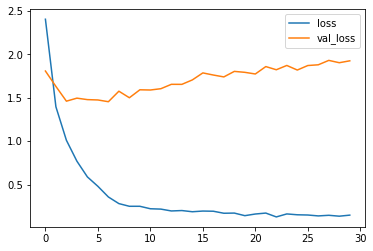

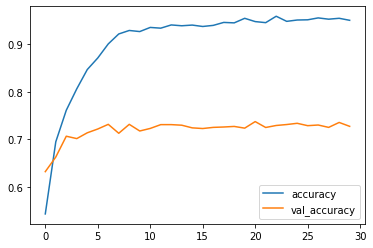

In [49]:
plot_loss_accuraccy(history_adam_glorot)

#### He ініціалізація

In [50]:
initializer_he = tf.initializers.HeNormal()
activation_relu = 'relu'

model_adam_he, history_adam_he = model_define_adam(initializer_he, activation_relu, 
                              input_shape=[64*64])

model_adam_he.save('models/model_adam_he')

Epoch 1/30
625/625 [==============================] - 10s 16ms/step - loss: 2.5110 - accuracy: 0.5444 - f1: 0.1121 - auc: 0.9145 - val_loss: 1.8972 - val_accuracy: 0.6406 - val_f1: 0.0957 - val_auc: 0.9352
Epoch 2/30
625/625 [==============================] - 10s 15ms/step - loss: 1.3559 - accuracy: 0.7096 - f1: 0.1594 - auc: 0.9626 - val_loss: 1.6180 - val_accuracy: 0.6832 - val_f1: 0.1388 - val_auc: 0.9502
Epoch 3/30
625/625 [==============================] - 10s 15ms/step - loss: 0.8946 - accuracy: 0.7863 - f1: 0.2668 - auc: 0.9801 - val_loss: 1.5671 - val_accuracy: 0.7106 - val_f1: 0.1742 - val_auc: 0.9499
Epoch 4/30
625/625 [==============================] - 9s 15ms/step - loss: 0.6035 - accuracy: 0.8417 - f1: 0.3921 - auc: 0.9888 - val_loss: 1.5987 - val_accuracy: 0.7280 - val_f1: 0.1932 - val_auc: 0.9463
Epoch 5/30
625/625 [==============================] - 10s 15ms/step - loss: 0.4001 - accuracy: 0.8880 - f1: 0.5327 - auc: 0.9944 - val_loss: 1.8539 - val_accuracy: 0.7218 - val_

In [51]:
pd.Series({k:v[-1] for k, v in history_adam_he.history.items()})

loss            0.178829
accuracy        0.969850
f1              0.876554
auc             0.993890
val_loss        5.824579
val_accuracy    0.736600
val_f1          0.212936
val_auc         0.894192
dtype: float64

Maximum accuracy: 0.7513999938964844


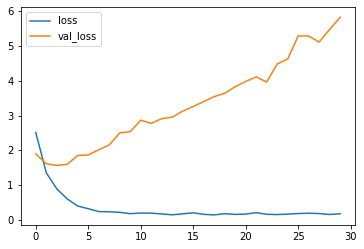

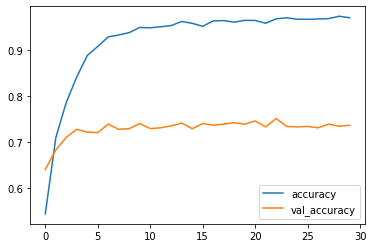

In [52]:
plot_loss_accuraccy(history_adam_he)

In [53]:
%time y_pred = model_adam_he.predict(X_valid)

CPU times: user 2.13 s, sys: 130 ms, total: 2.26 s
Wall time: 2.38 s


Accuracy in SGD:
- Normal: 0.6266
- Glorot: 0.7474
- He: 0.7646
 
Accuracy in Adam:
- Normal: 0.5974
- Glorot: 0.7274
- He: 0.7366

Отже, як бачимо якість навчання погіршився. Проте на графік втрат бачимо, що моделі перенавчаються і при меншій кількості епох навчання було би набагато кращим.

#### Далі дослідимо нормалiзацiю за мiнi-батчами

In [55]:
def model_batch(initializer, activation, learning_rate, input_shape=[1]):
    model = keras.Sequential([
    layers.Dense(512, input_shape=input_shape,
                 activation=activation,
                 kernel_initializer=initializer),
    layers.BatchNormalization(),
    layers.Dense(512, activation=activation,
                kernel_initializer=initializer),
    layers.BatchNormalization(),
    layers.Dense(512, activation=activation,
                kernel_initializer=initializer),
    layers.BatchNormalization(),
    layers.Dense(units=652, activation='softmax'),
    ])

    opt = keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    history = model.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=30,
                        batch_size=64)
    
    
    return model, history

In [56]:
model_batch_he, history_batch_he = model_batch(initializer_he, 
                                               activation_relu,
                                               0.01,
                                               input_shape=[64*64])

model_batch_he.save('models/model_batch_he')

Epoch 1/30
313/313 [==============================] - 11s 27ms/step - loss: 3.9347 - accuracy: 0.4023 - f1: 0.0755 - auc: 0.8018 - val_loss: 3.0202 - val_accuracy: 0.5236 - val_f1: 0.0406 - val_auc: 0.8550
Epoch 2/30
313/313 [==============================] - 5s 15ms/step - loss: 2.4795 - accuracy: 0.5847 - f1: 0.0587 - auc: 0.8937 - val_loss: 2.4052 - val_accuracy: 0.5990 - val_f1: 0.0622 - val_auc: 0.8924
Epoch 3/30
313/313 [==============================] - 5s 16ms/step - loss: 1.9524 - accuracy: 0.6599 - f1: 0.0908 - auc: 0.9290 - val_loss: 2.1151 - val_accuracy: 0.6344 - val_f1: 0.0806 - val_auc: 0.9086
Epoch 4/30
313/313 [==============================] - 5s 15ms/step - loss: 1.6126 - accuracy: 0.7119 - f1: 0.1234 - auc: 0.9486 - val_loss: 1.9560 - val_accuracy: 0.6634 - val_f1: 0.0975 - val_auc: 0.9199
Epoch 5/30
313/313 [==============================] - 5s 16ms/step - loss: 1.3696 - accuracy: 0.7545 - f1: 0.1559 - auc: 0.9622 - val_loss: 1.8348 - val_accuracy: 0.6788 - val_f1:

In [57]:
pd.Series({k:v[-1] for k, v in history_batch_he.history.items()})

loss            0.058591
accuracy        0.999750
f1              0.949060
auc             1.000000
val_loss        1.441621
val_accuracy    0.731200
val_f1          0.174195
val_auc         0.946716
dtype: float64

In [58]:
%time y_pred_batch = model_batch_he.predict(X_valid)

CPU times: user 2.12 s, sys: 127 ms, total: 2.24 s
Wall time: 1.06 s


Maximum accuracy: 0.7311999797821045


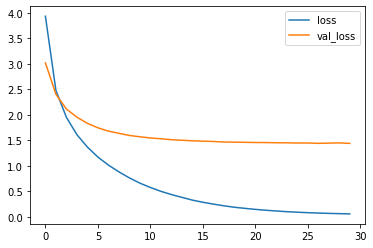

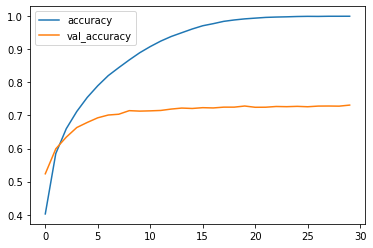

In [59]:
plot_loss_accuraccy(history_batch_he)

Отже з отриманих результатыв отримали, що модель навчається швидше. Навчання кожної епохи проходить за 5-7 секунд, а без нормалізації за міні-батчами виконується за 7-13 секунд.

Чи стала мережа менш чутливою до способу iнiцiалiзацiї ваг?
Перевіримо на наступній ініціалізації Glorot

In [60]:
model_batch_glorot, history_batch_glorot = model_batch(initializer_glorot, 
                                               activation_tanh,
                                                0.01,
                                               input_shape=[64*64])

model_batch_glorot.save('models/model_batch_glorot')

Epoch 1/30
313/313 [==============================] - 5s 14ms/step - loss: 3.4376 - accuracy: 0.4548 - f1: 0.0732 - auc: 0.8492 - val_loss: 2.6466 - val_accuracy: 0.5634 - val_f1: 0.0527 - val_auc: 0.8858
Epoch 2/30
313/313 [==============================] - 4s 14ms/step - loss: 2.1902 - accuracy: 0.6146 - f1: 0.0743 - auc: 0.9140 - val_loss: 2.1826 - val_accuracy: 0.6190 - val_f1: 0.0756 - val_auc: 0.9124
Epoch 3/30
313/313 [==============================] - 4s 13ms/step - loss: 1.7638 - accuracy: 0.6813 - f1: 0.1114 - auc: 0.9403 - val_loss: 1.9667 - val_accuracy: 0.6508 - val_f1: 0.0979 - val_auc: 0.9247
Epoch 4/30
313/313 [==============================] - 4s 13ms/step - loss: 1.4935 - accuracy: 0.7246 - f1: 0.1452 - auc: 0.9566 - val_loss: 1.8393 - val_accuracy: 0.6716 - val_f1: 0.1108 - val_auc: 0.9325
Epoch 5/30
313/313 [==============================] - 4s 13ms/step - loss: 1.2853 - accuracy: 0.7617 - f1: 0.1771 - auc: 0.9673 - val_loss: 1.7482 - val_accuracy: 0.6844 - val_f1: 

In [61]:
pd.Series({k:v[-1] for k, v in history_batch_glorot.history.items()})

loss            0.064002
accuracy        0.999750
f1              0.949321
auc             0.999975
val_loss        1.396072
val_accuracy    0.731200
val_f1          0.185579
val_auc         0.951677
dtype: float64

Отже бачимо, що результат accuracy однаковий як  при glorot ініціалізації так і при he ініціалізації, тобто модель не чутлива до методу ініціалізації ваг.

Збільшимо швидкість навчання 

In [62]:
model_batch_he1, history_batch_he1 = model_batch(initializer_he, 
                                               activation_relu,
                                               0.1,
                                               input_shape=[64*64])

model_batch_he1.save('models/model_batch_he1')

Epoch 1/30
313/313 [==============================] - 6s 17ms/step - loss: 2.3282 - accuracy: 0.5932 - f1: 0.1143 - auc: 0.9082 - val_loss: 1.6778 - val_accuracy: 0.6830 - val_f1: 0.1195 - val_auc: 0.9370
Epoch 2/30
313/313 [==============================] - 5s 17ms/step - loss: 1.0786 - accuracy: 0.7836 - f1: 0.2117 - auc: 0.9725 - val_loss: 1.3939 - val_accuracy: 0.7290 - val_f1: 0.1747 - val_auc: 0.9520
Epoch 3/30
313/313 [==============================] - 5s 17ms/step - loss: 0.6182 - accuracy: 0.8771 - f1: 0.3531 - auc: 0.9901 - val_loss: 1.2460 - val_accuracy: 0.7536 - val_f1: 0.1984 - val_auc: 0.9587
Epoch 4/30
313/313 [==============================] - 5s 17ms/step - loss: 0.3412 - accuracy: 0.9384 - f1: 0.5193 - auc: 0.9975 - val_loss: 1.2185 - val_accuracy: 0.7560 - val_f1: 0.2192 - val_auc: 0.9618
Epoch 5/30
313/313 [==============================] - 5s 17ms/step - loss: 0.1640 - accuracy: 0.9789 - f1: 0.7163 - auc: 0.9997 - val_loss: 1.1663 - val_accuracy: 0.7682 - val_f1: 

In [63]:
pd.Series({k:v[-1] for k, v in history_batch_he1.history.items()})

loss            0.003281
accuracy        0.999900
f1              0.950917
auc             1.000000
val_loss        1.176229
val_accuracy    0.781400
val_f1          0.240372
val_auc         0.956217
dtype: float64

Коли збільшили параметр швидкості навчання то спостерігаємо, що модель стала більш точною.

Maximum accuracy: 0.7856000065803528


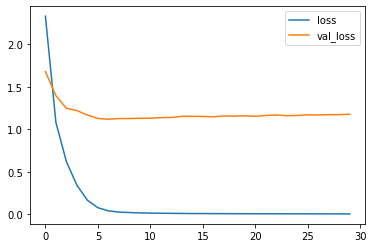

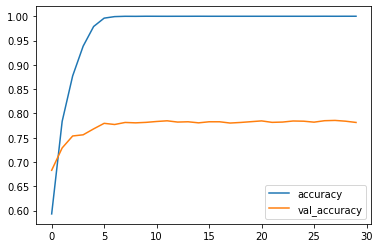

In [64]:
plot_loss_accuraccy(history_batch_he1)

In [68]:
initializer_he = tf.initializers.HeNormal()
activation_relu = 'relu'

learn_rate = [0.1, 0.2, 0.5, 0.8, 1.0]
res = pd.DataFrame()

for rate in learn_rate:
    model = keras.Sequential([
    layers.Dense(512, input_shape=[64*64],
                 activation=activation_relu,
                 kernel_initializer=initializer_he),
    layers.BatchNormalization(),
    layers.Dense(512, activation=activation_relu,
                kernel_initializer=initializer_he),
    layers.BatchNormalization(),
    layers.Dense(512, activation=activation_relu,
                kernel_initializer=initializer_he),
    layers.BatchNormalization(),
    layers.Dense(units=652, activation='softmax'),
    ])

    opt = keras.optimizers.SGD(learning_rate=rate)
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    history = model.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=30,
                        batch_size=64)


    res[f'rate={rate}'] = pd.Series({i:j[-1] for i, j in history.history.items()})
    
    model.save(f'models/model_learn_rate{rate}')

Epoch 1/30
313/313 [==============================] - 6s 17ms/step - loss: 2.3241 - accuracy: 0.5980 - f1: 0.1516 - auc: 0.9105 - val_loss: 1.6613 - val_accuracy: 0.6892 - val_f1: 0.1327 - val_auc: 0.9389
Epoch 2/30
313/313 [==============================] - 5s 15ms/step - loss: 1.0689 - accuracy: 0.7879 - f1: 0.2133 - auc: 0.9721 - val_loss: 1.3826 - val_accuracy: 0.7362 - val_f1: 0.1788 - val_auc: 0.9542
Epoch 3/30
313/313 [==============================] - 5s 15ms/step - loss: 0.6146 - accuracy: 0.8773 - f1: 0.3583 - auc: 0.9905 - val_loss: 1.2252 - val_accuracy: 0.7564 - val_f1: 0.1965 - val_auc: 0.9607
Epoch 4/30
313/313 [==============================] - 5s 16ms/step - loss: 0.3266 - accuracy: 0.9423 - f1: 0.5343 - auc: 0.9981 - val_loss: 1.1664 - val_accuracy: 0.7668 - val_f1: 0.2178 - val_auc: 0.9624
Epoch 5/30
313/313 [==============================] - 5s 15ms/step - loss: 0.1518 - accuracy: 0.9811 - f1: 0.7287 - auc: 0.9998 - val_loss: 1.1294 - val_accuracy: 0.7782 - val_f1: 

313/313 [==============================] - 4s 13ms/step - loss: 0.0076 - accuracy: 0.9998 - f1: 0.9509 - auc: 1.0000 - val_loss: 1.0166 - val_accuracy: 0.8054 - val_f1: 0.2640 - val_auc: 0.9635
Epoch 11/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0068 - accuracy: 0.9997 - f1: 0.9509 - auc: 1.0000 - val_loss: 1.0204 - val_accuracy: 0.8072 - val_f1: 0.2664 - val_auc: 0.9635
Epoch 12/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0058 - accuracy: 0.9998 - f1: 0.9509 - auc: 1.0000 - val_loss: 1.0281 - val_accuracy: 0.8060 - val_f1: 0.2669 - val_auc: 0.9633
Epoch 13/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0054 - accuracy: 0.9998 - f1: 0.9509 - auc: 0.9999 - val_loss: 1.0250 - val_accuracy: 0.8054 - val_f1: 0.2628 - val_auc: 0.9628
Epoch 14/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0047 - accuracy: 0.9998 - f1: 0.9509 - auc: 1.0000 - val_loss: 1.0319 - val_accuracy: 0.8084 - val_f1: 0.2706 

313/313 [==============================] - 5s 15ms/step - loss: 0.0017 - accuracy: 0.9999 - f1: 0.9519 - auc: 1.0000 - val_loss: 1.0641 - val_accuracy: 0.8190 - val_f1: 0.2887 - val_auc: 0.9591
Epoch 20/30
313/313 [==============================] - 5s 15ms/step - loss: 0.0020 - accuracy: 0.9998 - f1: 0.9509 - auc: 1.0000 - val_loss: 1.0595 - val_accuracy: 0.8228 - val_f1: 0.2928 - val_auc: 0.9590
Epoch 21/30
313/313 [==============================] - 5s 15ms/step - loss: 0.0016 - accuracy: 0.9998 - f1: 0.9509 - auc: 1.0000 - val_loss: 1.0568 - val_accuracy: 0.8238 - val_f1: 0.2947 - val_auc: 0.9597
Epoch 22/30
313/313 [==============================] - 4s 14ms/step - loss: 0.0017 - accuracy: 0.9998 - f1: 0.9509 - auc: 1.0000 - val_loss: 1.0581 - val_accuracy: 0.8214 - val_f1: 0.2894 - val_auc: 0.9593
Epoch 23/30
313/313 [==============================] - 8s 24ms/step - loss: 0.0014 - accuracy: 0.9998 - f1: 0.9509 - auc: 1.0000 - val_loss: 1.0591 - val_accuracy: 0.8226 - val_f1: 0.2901 

313/313 [==============================] - 5s 17ms/step - loss: 0.0014 - accuracy: 0.9998 - f1: 0.9509 - auc: 1.0000 - val_loss: 1.2908 - val_accuracy: 0.8166 - val_f1: 0.3006 - val_auc: 0.9540
Epoch 29/30
313/313 [==============================] - 5s 16ms/step - loss: 9.3004e-04 - accuracy: 0.9999 - f1: 0.9509 - auc: 1.0000 - val_loss: 1.2767 - val_accuracy: 0.8208 - val_f1: 0.3040 - val_auc: 0.9540
Epoch 30/30
313/313 [==============================] - 7s 23ms/step - loss: 9.3836e-04 - accuracy: 0.9998 - f1: 0.9509 - auc: 1.0000 - val_loss: 1.2760 - val_accuracy: 0.8192 - val_f1: 0.3021 - val_auc: 0.9545
INFO:tensorflow:Assets written to: models/model_learn_rate0.8/assets
Assets written to: models/model_learn_rate0.8/assets
Epoch 1/30
313/313 [==============================] - 7s 18ms/step - loss: 2.8083 - accuracy: 0.5224 - f1: 0.1429 - auc: 0.9032 - val_loss: 1.8541 - val_accuracy: 0.6304 - val_f1: 0.1067 - val_auc: 0.9334
Epoch 2/30
313/313 [==============================] - 6s 19

In [69]:
res

,rate=0.1,rate=0.2,rate=0.5,rate=0.8,rate=1.0
loss,0.003269,0.001836,0.001099,0.000938,0.005320
accuracy,0.999900,0.999850,0.999850,0.999850,0.998900
f1,0.951939,0.950906,0.950915,0.950914,0.951250
auc,0.999975,1.000000,1.000000,1.000000,0.999950
val_loss,1.135244,1.055170,1.071785,1.275965,1.573034
val_accuracy,0.790000,0.806600,0.822200,0.819200,0.809000
val_f1,0.248531,0.267413,0.290604,0.302085,0.294837
val_auc,0.958634,0.961756,0.958564,0.954501,0.944097


Найкращий результат показала модель із learning_rate=0.5

#### Dropout

In [70]:
initializer_he = tf.initializers.HeNormal()
activation_relu = 'relu'

ps = [0.01, 0.05, 0.1, 0.2, 0.5]
res_p = pd.DataFrame()

for p in ps:
    model = keras.Sequential([
        layers.Dense(512, input_shape=[64*64],
                     activation=activation_relu,
                     kernel_initializer=initializer_he),
        layers.Dropout(p),
        layers.BatchNormalization(),
        layers.Dense(512, activation=activation_relu,
                    kernel_initializer=initializer_he),
        layers.Dropout(p),
        layers.BatchNormalization(),
        layers.Dense(512, activation=activation_relu,
                    kernel_initializer=initializer_he),
        layers.Dropout(p),
        layers.BatchNormalization(),
        layers.Dense(units=652, activation='softmax'),
    ])

    opt = tf.keras.optimizers.SGD(learning_rate=0.5)
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    logdir = os.path.join("logs/kkanji", str(p))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    history = model.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=30,
                        batch_size=64,
                        callbacks=[tensorboard_callback])
    
    res_p[f'p={p}'] = pd.Series({i:j[-1] for i, j in history.history.items()})
    
    model.save(f'models/model_dropout{p}')

Epoch 1/30
313/313 [==============================] - 16s 45ms/step - loss: 2.2180 - accuracy: 0.5890 - f1: 0.1693 - auc: 0.9161 - val_loss: 1.7187 - val_accuracy: 0.6600 - val_f1: 0.1506 - val_auc: 0.9383
Epoch 2/30
313/313 [==============================] - 6s 18ms/step - loss: 0.9894 - accuracy: 0.7765 - f1: 0.2586 - auc: 0.9749 - val_loss: 1.3124 - val_accuracy: 0.7374 - val_f1: 0.2152 - val_auc: 0.9559
Epoch 3/30
313/313 [==============================] - 5s 16ms/step - loss: 0.5596 - accuracy: 0.8612 - f1: 0.4259 - auc: 0.9907 - val_loss: 1.3694 - val_accuracy: 0.7344 - val_f1: 0.2256 - val_auc: 0.9519
Epoch 4/30
313/313 [==============================] - 5s 17ms/step - loss: 0.2892 - accuracy: 0.9235 - f1: 0.6240 - auc: 0.9979 - val_loss: 1.2750 - val_accuracy: 0.7524 - val_f1: 0.2446 - val_auc: 0.9562
Epoch 5/30
313/313 [==============================] - 6s 18ms/step - loss: 0.1441 - accuracy: 0.9624 - f1: 0.8431 - auc: 0.9994 - val_loss: 1.2772 - val_accuracy: 0.7696 - val_f1:

313/313 [==============================] - 6s 20ms/step - loss: 0.0681 - accuracy: 0.9814 - f1: 0.9299 - auc: 0.9997 - val_loss: 1.2091 - val_accuracy: 0.7974 - val_f1: 0.2651 - val_auc: 0.9564
Epoch 11/30
313/313 [==============================] - 6s 19ms/step - loss: 0.0543 - accuracy: 0.9849 - f1: 0.9306 - auc: 0.9997 - val_loss: 1.2371 - val_accuracy: 0.7968 - val_f1: 0.2770 - val_auc: 0.9541
Epoch 12/30
313/313 [==============================] - 6s 19ms/step - loss: 0.0541 - accuracy: 0.9840 - f1: 0.9284 - auc: 0.9998 - val_loss: 1.2528 - val_accuracy: 0.7974 - val_f1: 0.2771 - val_auc: 0.9550
Epoch 13/30
313/313 [==============================] - 6s 19ms/step - loss: 0.0442 - accuracy: 0.9871 - f1: 0.9366 - auc: 0.9999 - val_loss: 1.2191 - val_accuracy: 0.8026 - val_f1: 0.2781 - val_auc: 0.9561
Epoch 14/30
313/313 [==============================] - 6s 19ms/step - loss: 0.0355 - accuracy: 0.9904 - f1: 0.9408 - auc: 0.9998 - val_loss: 1.2641 - val_accuracy: 0.7986 - val_f1: 0.2727 

313/313 [==============================] - 7s 21ms/step - loss: 0.0680 - accuracy: 0.9794 - f1: 0.9207 - auc: 0.9993 - val_loss: 1.2835 - val_accuracy: 0.8060 - val_f1: 0.2919 - val_auc: 0.9525
Epoch 20/30
313/313 [==============================] - 6s 20ms/step - loss: 0.0667 - accuracy: 0.9800 - f1: 0.9221 - auc: 0.9994 - val_loss: 1.3009 - val_accuracy: 0.8000 - val_f1: 0.2858 - val_auc: 0.9520
Epoch 21/30
313/313 [==============================] - 7s 21ms/step - loss: 0.0569 - accuracy: 0.9819 - f1: 0.9226 - auc: 0.9997 - val_loss: 1.3191 - val_accuracy: 0.8048 - val_f1: 0.2824 - val_auc: 0.9521
Epoch 22/30
313/313 [==============================] - 6s 21ms/step - loss: 0.0587 - accuracy: 0.9816 - f1: 0.9227 - auc: 0.9996 - val_loss: 1.3190 - val_accuracy: 0.8088 - val_f1: 0.2950 - val_auc: 0.9517
Epoch 23/30
313/313 [==============================] - 7s 22ms/step - loss: 0.0551 - accuracy: 0.9833 - f1: 0.9222 - auc: 0.9995 - val_loss: 1.3137 - val_accuracy: 0.8038 - val_f1: 0.2894 

313/313 [==============================] - 6s 19ms/step - loss: 0.1667 - accuracy: 0.9477 - f1: 0.8513 - auc: 0.9983 - val_loss: 1.2906 - val_accuracy: 0.8076 - val_f1: 0.2883 - val_auc: 0.9525
Epoch 29/30
313/313 [==============================] - 6s 18ms/step - loss: 0.1519 - accuracy: 0.9540 - f1: 0.8694 - auc: 0.9984 - val_loss: 1.2763 - val_accuracy: 0.8064 - val_f1: 0.2819 - val_auc: 0.9523
Epoch 30/30
313/313 [==============================] - 6s 18ms/step - loss: 0.1526 - accuracy: 0.9528 - f1: 0.8621 - auc: 0.9982 - val_loss: 1.2867 - val_accuracy: 0.8032 - val_f1: 0.2848 - val_auc: 0.9539
INFO:tensorflow:Assets written to: models/model_dropout0.2/assets
Assets written to: models/model_dropout0.2/assets
Epoch 1/30
313/313 [==============================] - 12s 35ms/step - loss: 3.7893 - accuracy: 0.3335 - f1: 0.1011 - auc: 0.8446 - val_loss: 2.5522 - val_accuracy: 0.5026 - val_f1: 0.0395 - val_auc: 0.9042
Epoch 2/30
313/313 [==============================] - 6s 20ms/step - los

In [71]:
res_p

,p=0.01,p=0.05,p=0.1,p=0.2,p=0.5
loss,0.001300,0.012483,0.048178,0.152597,1.410994
accuracy,0.999900,0.996900,0.985300,0.952750,0.662750
f1,0.950916,0.947159,0.928616,0.862059,0.164028
auc,1.000000,0.999900,0.999348,0.998158,0.968239
val_loss,1.093763,1.297053,1.353716,1.286681,1.261203
val_accuracy,0.829400,0.815600,0.808600,0.803200,0.732800
val_f1,0.303293,0.296234,0.283077,0.284820,0.178687
val_auc,0.959774,0.953291,0.951073,0.953938,0.964371


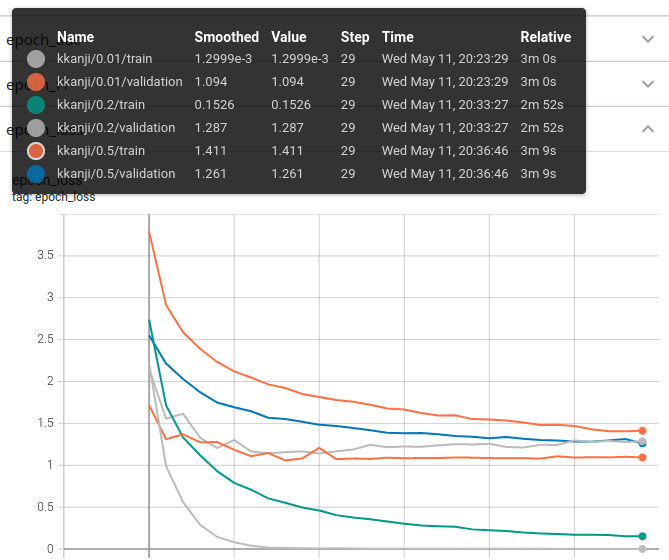

Отже отримали результат, що модель з дропаутом та малою (p->0) ймовірностю відключення нейронів навчається трохи краще, ніж ммодель без дропауту. А коли коефіцієнт p збільшуємо то погіршується якість роботи моделі.

In [80]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 43066), started 0:02:37 ago. (Use '!kill 43066' to kill it.)

In [81]:
!kill 43066

#### Early stopping

Я уже згадув вище, що коли модель надто охоче вивчає шум, функція втрат перевірки може почати збільшуватися під час навчання. Щоб запобігти цьому, ми можемо просто припинити навчання, коли втрата на первірочні множині більше не зменшується. Переривання навчання таким чином називається ранньою зупинкою. </br>
Як тільки ми виявимо, що функція втрат перевірки знову починає зростати, ми можемо скинути ваги назад до мінімуму. Це гарантує, що модель не буде продовжувати вивчати шум і переповнювати модель не потрібними даними. 

In [76]:
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential([
        layers.Dense(512, input_shape=[64*64],
                     activation=activation_relu,
                     kernel_initializer=initializer_he),
        layers.Dropout(0.01),
        layers.BatchNormalization(),
        layers.Dense(512, activation=activation_relu,
                    kernel_initializer=initializer_he),
        layers.Dropout(0.01),
        layers.BatchNormalization(),
        layers.Dense(512, activation=activation_relu,
                    kernel_initializer=initializer_he),
        layers.Dropout(0.01),
        layers.BatchNormalization(),
        layers.Dense(units=652, activation='softmax'),
    ])

opt = tf.keras.optimizers.SGD(learning_rate=0.5)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=metrics
)

logdir = os.path.join("logs/kkanji/early_stop")
callback_list = [
    keras.callbacks.TensorBoard(
        logdir, histogram_freq=1
    ),
    keras.callbacks.EarlyStopping(
        min_delta=0.001, patience=20, restore_best_weights=True
    )
]

history = model.fit(X_train,y_train, 
                    validation_data=(X_valid, y_valid),
                    epochs=30,
                    batch_size=64,
                    callbacks=[callback_list])

model.save('models/model_early_stop')

Epoch 1/30
313/313 [==============================] - 10s 25ms/step - loss: 2.1904 - accuracy: 0.5922 - f1: 0.1286 - auc: 0.9224 - val_loss: 2.0340 - val_accuracy: 0.6318 - val_f1: 0.1343 - val_auc: 0.9211
Epoch 2/30
313/313 [==============================] - 6s 20ms/step - loss: 0.9987 - accuracy: 0.7750 - f1: 0.2612 - auc: 0.9738 - val_loss: 1.4302 - val_accuracy: 0.7202 - val_f1: 0.2027 - val_auc: 0.9515
Epoch 3/30
313/313 [==============================] - 6s 20ms/step - loss: 0.5737 - accuracy: 0.8578 - f1: 0.4139 - auc: 0.9901 - val_loss: 1.3220 - val_accuracy: 0.7326 - val_f1: 0.2174 - val_auc: 0.9562
Epoch 4/30
313/313 [==============================] - 8s 24ms/step - loss: 0.3028 - accuracy: 0.9197 - f1: 0.6272 - auc: 0.9976 - val_loss: 1.2963 - val_accuracy: 0.7574 - val_f1: 0.2403 - val_auc: 0.9538
Epoch 5/30
313/313 [==============================] - 5s 17ms/step - loss: 0.1553 - accuracy: 0.9589 - f1: 0.8318 - auc: 0.9993 - val_loss: 1.1333 - val_accuracy: 0.7864 - val_f1:

In [77]:
pd.Series({k:v[-1] for k, v in history.history.items()})

loss            0.001484
accuracy        0.999850
f1              0.950912
auc             1.000000
val_loss        1.097200
val_accuracy    0.825200
val_f1          0.301242
val_auc         0.959771
dtype: float64

In [78]:
score = model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.0694 - accuracy: 0.8162 - f1: 0.2935 - auc: 0.9625


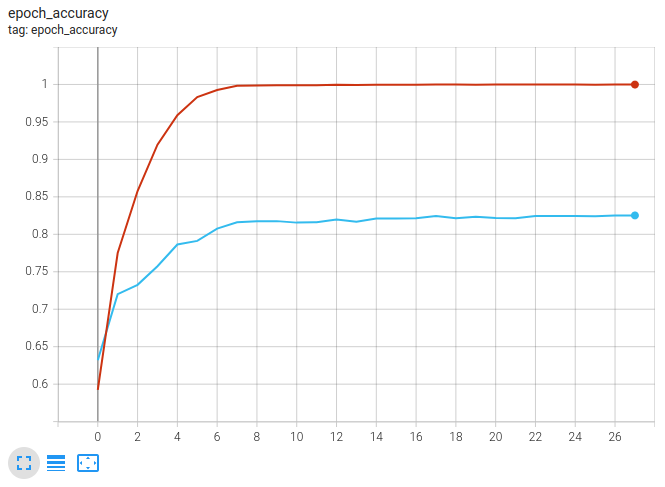
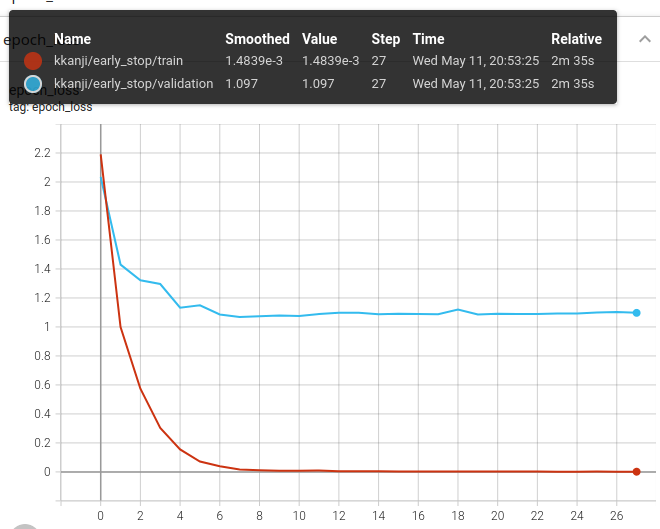

Так як модель має функцію втрат, яка не зростає то модель із використанням ранньої зупинки не буде відігравати велику роль.

Створимо ще моделі із застосуванням регуляризацій

In [97]:
res_reg = pd.DataFrame()
res_reg["without"] = res_p["p=0.01"]

for regularization in['l2', 'l1']:
    
    model = keras.Sequential([
        layers.Dense(512, input_shape=[64*64],
                     activation=activation_relu,
                     kernel_initializer=initializer_he,
                     kernel_regularizer=regularization,
                     bias_regularizer=regularization
                    ),
        layers.Dropout(0.01),
        layers.BatchNormalization(),
        layers.Dense(512, activation=activation_relu,
                    kernel_initializer=initializer_he,
                    kernel_regularizer=regularization,
                    bias_regularizer=regularization
                    ),
        layers.Dropout(0.01),
        layers.BatchNormalization(),
        layers.Dense(512, activation=activation_relu,
                    kernel_initializer=initializer_he,
                    kernel_regularizer=regularization,
                    bias_regularizer=regularization
                    ),
        layers.Dropout(0.01),
        layers.BatchNormalization(),
        layers.Dense(units=652, activation='softmax'),
    ])

    opt = tf.keras.optimizers.SGD(learning_rate=0.5)

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=metrics
    )

    logdir = os.path.join("logs/kkanji/regularization", regularization)
    callback_list = [
        keras.callbacks.TensorBoard(
            logdir, histogram_freq=1
        ),
        keras.callbacks.EarlyStopping(
            min_delta=0.001, patience=20, restore_best_weights=True
        )
    ]

    history = model.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=30,
                        batch_size=64,
                        callbacks=[callback_list])
    
    res_reg[regularization] = pd.Series({i:j[-1] for i, j in history.history.items()})

    model.save(f'models/model_r{regularization}')

Epoch 1/30
313/313 [==============================] - 45s 131ms/step - loss: 9.8316 - accuracy: 0.4485 - f1: 0.0464 - auc: 0.8303 - val_loss: 6.0787 - val_accuracy: 0.3320 - val_f1: 0.0272 - val_auc: 0.8367
Epoch 2/30
313/313 [==============================] - 72s 197ms/step - loss: 4.0003 - accuracy: 0.5114 - f1: 0.0740 - auc: 0.9199 - val_loss: 4.7302 - val_accuracy: 0.3870 - val_f1: 0.0341 - val_auc: 0.8653
Epoch 3/30
313/313 [==============================] - 31s 98ms/step - loss: 3.5560 - accuracy: 0.5350 - f1: 0.0877 - auc: 0.9349 - val_loss: 4.5336 - val_accuracy: 0.4036 - val_f1: 0.0442 - val_auc: 0.8742
Epoch 4/30
313/313 [==============================] - 10s 31ms/step - loss: 3.3634 - accuracy: 0.5478 - f1: 0.0969 - auc: 0.9410 - val_loss: 4.4020 - val_accuracy: 0.4192 - val_f1: 0.0509 - val_auc: 0.8861
Epoch 5/30
313/313 [==============================] - 11s 36ms/step - loss: 3.2195 - accuracy: 0.5543 - f1: 0.1035 - auc: 0.9455 - val_loss: 4.0597 - val_accuracy: 0.4376 - v

IOStream.flush timed out


313/313 [==============================] - 287s 770ms/step - loss: 111.3178 - accuracy: 0.0830 - f1: 0.0246 - auc: 0.7571 - val_loss: 89.0586 - val_accuracy: 0.0264 - val_f1: 1.2429e-04 - val_auc: 0.7865
Epoch 2/30
313/313 [==============================] - 72s 226ms/step - loss: 81.4076 - accuracy: 0.1168 - f1: 0.0018 - auc: 0.7941 - val_loss: 84.0722 - val_accuracy: 0.1232 - val_f1: 9.5089e-04 - val_auc: 0.6849
Epoch 3/30
313/313 [==============================] - 27s 86ms/step - loss: 79.5394 - accuracy: 0.1431 - f1: 0.0023 - auc: 0.8038 - val_loss: 85.7775 - val_accuracy: 0.1180 - val_f1: 9.4999e-04 - val_auc: 0.6832
Epoch 4/30
313/313 [==============================] - 16s 52ms/step - loss: 78.0590 - accuracy: 0.1404 - f1: 0.0022 - auc: 0.8099 - val_loss: 95.0772 - val_accuracy: 0.0686 - val_f1: 4.3411e-04 - val_auc: 0.5550
Epoch 5/30
313/313 [==============================] - 14s 46ms/step - loss: 76.8794 - accuracy: 0.1613 - f1: 0.0030 - auc: 0.8230 - val_loss: 78.7641 - val_acc

In [98]:
res_reg

,without,l2,l1
loss,0.001300,2.903034,73.671806
accuracy,0.999900,0.598650,0.197250
f1,0.950916,0.170662,0.004175
auc,1.000000,0.966981,0.849086
val_loss,1.093763,3.852709,74.981277
val_accuracy,0.829400,0.474200,0.135000
val_f1,0.303293,0.079988,0.002436
val_auc,0.959774,0.916639,0.739403


Модель без регуляризації даних є більш точною моделю

##### Отже найкраща модель це модель 'models/model_early_stop'
Тому саме цю модель ми будемо використовувати для тестування даних


### Протестуємо на перевірочних даних

In [99]:
model = keras.models.load_model('models/model_early_stop')

In [102]:
labels = np.unique(Y)

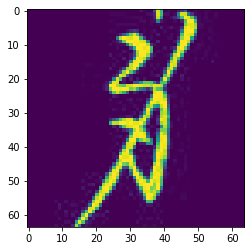

Prediction:  3
True:  3


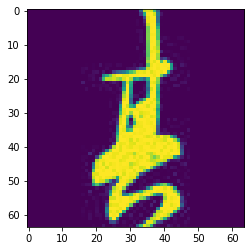

Prediction:  406
True:  406


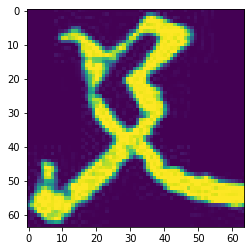

Prediction:  436
True:  436


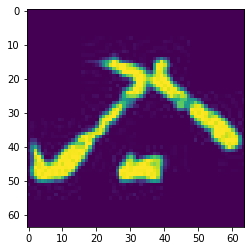

Prediction:  227
True:  227


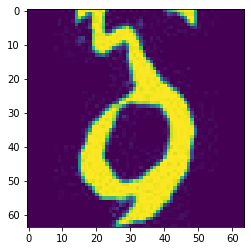

Prediction:  651
True:  651


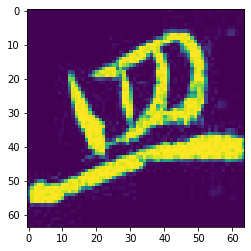

Prediction:  617
True:  617


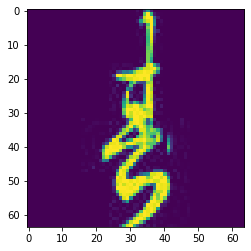

Prediction:  406
True:  406


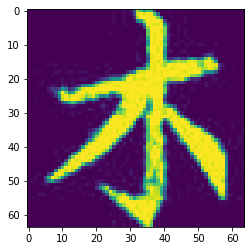

Prediction:  254
True:  254


In [134]:
indexes = np.random.randint(len(y_valid), size=8)

for l, i in enumerate(indexes):
    plt.imshow(X_valid[i].reshape(64,64))
    plt.show()
    
    prediction = model.predict(X_valid[i].reshape(-1, 64*64))
    print("Prediction: ", prediction.argmax())
    print("True: ", y_valid[i].argmax())

### Висновок 
Протягом даної лабораторної роботи було досліджено та побудовоні моделі на наборі даних Kuzushiji-Kanji. Після дослідження було визначено таку модель:

In [133]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 512)               2097664   
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_54 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_111 (Dense)           (None, 512)               262656    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_55 (Bat  (None, 512)              2048      
 chNormalization)                                    

Під час тестування моделі не було знайденно хибно спрацьованої класифікації. Але при значеннях val_accuracy=0.825200 та val_auc = 0.959771 ми бачимо, що модель є не точною і похибки все таки присутні під час класифікації. Натомість варто зауважити, що дана модель має 652 класи. Тобто навіть при такій великій кількості класів модель, яка є доволі простою, показує дуже хороші результати. 